# Geospatial exam - Riccardo Zorzoni (mat. 220500)

## Package and Libraries

### Package

In [1]:
try:
  import rtree
except ModuleNotFoundError as e:
  !apt-get install libspatialindex-dev > /dev/null
  !pip install rtree > /dev/null
  import rtree

In [2]:
!pip install contextily > /dev/null

In [3]:
!pip install seaborn > /dev/null

In [4]:
!pip install sklearn > /dev/null

In [5]:
!pip install pygeos > /dev/null

In [6]:
!pip install geopandas > /dev/null

In [7]:
!pip install pyrosm > /dev/null

### Libraries

In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import contextily as ctx

from sklearn.cluster import dbscan

import random

import pyrosm
from pyrosm.data import sources

from geopy.geocoders import Nominatim
from geopy.geocoders import ArcGIS

# import osmnx as ox

from shapely.geometry import Point, LineString
from shapely.ops import transform
import pyproj

/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Data preparation

### Airbnb data

In [9]:
# Load data from my github repository
data_url = 'https://raw.githubusercontent.com/Richip9114/GeospExam/main/bologna_listings.csv'
bologna_airbnb = pd.read_csv(data_url)

In [10]:
# Pick only the room/house with at least 90 days in a year
bologna_airbnb = bologna_airbnb[bologna_airbnb['availability_365'] > 90 ]
# Remove the not useful column for the analysis
labels_to_delete = ['minimum_nights','number_of_reviews','last_review','reviews_per_month','calculated_host_listings_count','availability_365']
bologna_airbnb = bologna_airbnb.drop(labels=labels_to_delete, axis=1)

In [11]:
bologna_airbnb

id                                   name  ...        room_type price
0        42196    50 sm Studio in the historic centre  ...  Entire home/apt    68
1        46352             A room in Pasolini's house  ...     Private room    29
2        59697         BOLOGNA CENTRE RELAX & COMFORT  ...  Entire home/apt    70
3        70366                             Fuoriporta  ...  Entire home/apt    60
5        85368                   Garden House Bologna  ...  Entire home/apt   130
...        ...                                    ...  ...              ...   ...
3848  46231929        Gethekey S.Vitale camera doppia  ...     Private room    80
3849  46232967  Gethekey S.Vitale camera matrimoniale  ...     Private room    80
3850  46233340       Gethekey S.Vitale camera singola  ...     Private room    80
3851  46235521        Camera matrimoniale o due letti  ...     Private room    45
3852  46278302                          Il Mascherone  ...  Entire home/apt    78

[2359 rows x 10 columns]

In [12]:
# Create the geodataframe with geopandas
geo_bologna = gpd.GeoDataFrame(bologna_airbnb,crs='EPSG:4326', geometry=gpd.points_from_xy(bologna_airbnb['longitude'], bologna_airbnb['latitude']))
geo_bologna

id  ...                   geometry
0        42196  ...  POINT (11.34786 44.48507)
1        46352  ...  POINT (11.33514 44.49168)
2        59697  ...  POINT (11.34124 44.48817)
3        70366  ...  POINT (11.32206 44.49699)
5        85368  ...  POINT (11.35672 44.47834)
...        ...  ...                        ...
3848  46231929  ...  POINT (11.35026 44.49402)
3849  46232967  ...  POINT (11.34900 44.49484)
3850  46233340  ...  POINT (11.35030 44.49536)
3851  46235521  ...  POINT (11.34610 44.49706)
3852  46278302  ...  POINT (11.34831 44.49651)

[2359 rows x 11 columns]

In [13]:
# To see the possibilities
ctx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH'])

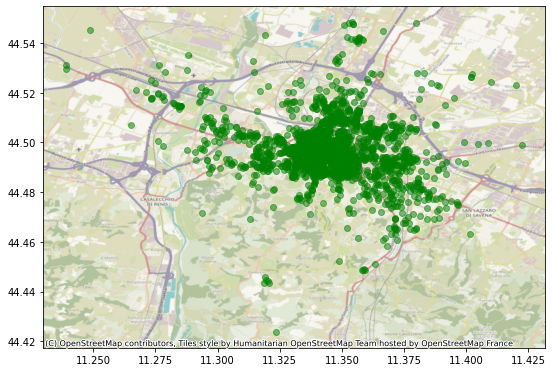

In [14]:
# Plot the points on a map using contextily (provider: OSM - key: HOT)
ax = geo_bologna.plot(alpha=0.5, color="green", figsize=(9, 9))
ctx.add_basemap(ax, crs=geo_bologna.crs.to_string(),
                source=ctx.providers.OpenStreetMap.HOT)

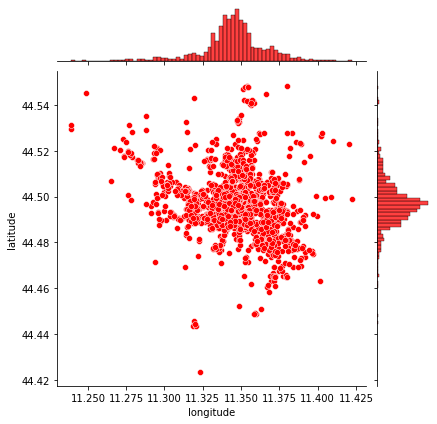

In [15]:
# Plot the points with seaborn to see the distribution frequency
sns.jointplot(x='longitude', y='latitude', color="red", data=geo_bologna);

In [16]:
# bounding box
geo_bologna['x'] = geo_bologna.to_crs(epsg=3857).geometry.x
geo_bologna['y'] = geo_bologna.to_crs(epsg=3857).geometry.y
bounding_box = [geo_bologna.x.min(), geo_bologna.y.min(), geo_bologna.x.max(), geo_bologna.y.max()]

# basemap, basemap_extent = ctx.bounds2img(*bounding_box, zoom=10,source = ctx.providers.Esri.NatGeoWorldMap)
basemap, basemap_extent = ctx.bounds2img(*bounding_box, zoom=10,source = ctx.providers.Stamen.TerrainBackground)

data_extent = [geo_bologna.x.min(), geo_bologna.x.max(), geo_bologna.y.min(), geo_bologna.y.max()]

hexagon

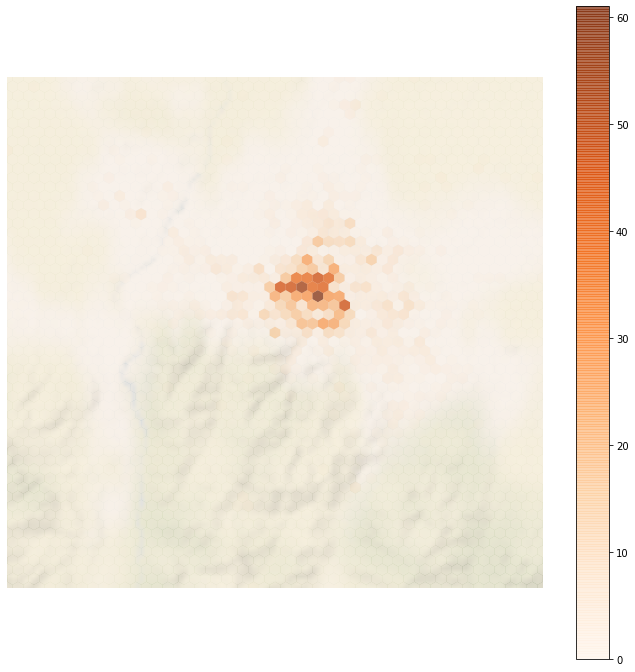

In [17]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Add map tiles for context
ax.imshow(basemap, extent=basemap_extent, interpolation='bilinear')
# Generate and add hexbin with 50 hexagons in each 
# dimension, no borderlines, 70% transparency (alpha),
# and the reverse Oranges colormap
hb = ax.hexbin(x=geo_bologna['x'], 
               y=geo_bologna['y'],
               gridsize=50, linewidths=0,
               alpha=0.7, cmap='Oranges')
ax.axis(data_extent)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()


kde

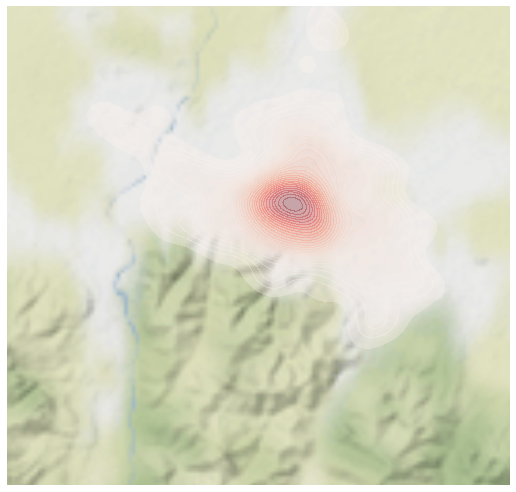

In [18]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add map tiles for context
ax.imshow(basemap, extent=basemap_extent, interpolation='bilinear')
# Generate and add KDE with a shading of 30 gradients 
# coloured contours, 30% of transparency (alpha),
# and the reverse Reds colormap
sns.kdeplot(x=geo_bologna['x'], y=geo_bologna['y'],
                n_levels=30, shade=True,
                alpha=0.3, cmap='Reds')
# Remove axes
ax.axis(data_extent)
ax.set_axis_off()


Use of DBSCAN (Density-Based Spatial Clustering and Application with Noise), that is a density based clustering algorithm
- eps is the radius of area around a point, in this case 140 meters;
- minp is the minimum points that must be in the area, in this case the 1%.


In [19]:
minp = np.round(geo_bologna.shape[0] * 0.01)
print('minimum points: ', minp)
clusterindexes, labels = dbscan(geo_bologna[['x', 'y']], eps=140, min_samples=minp) #140 max, with 150 there are 2 cluster instead of 6
print("len cluster index: ",  len(clusterindexes) )
labels = pd.Series(labels, index=geo_bologna.index)
print("labels: ", labels.unique())

minimum points:  24.0
len cluster index:  222
labels:  [-1  1  2  3  0  4  5]


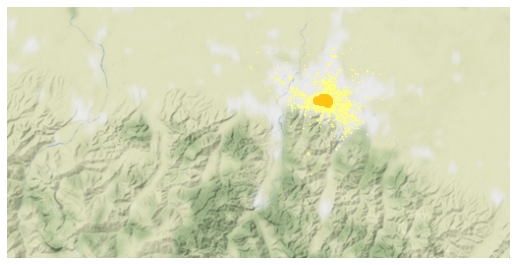

In [20]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add base layer with tiles for context
ax.imshow(basemap, extent=basemap_extent, interpolation='bilinear')

# Subset points that are not part of any cluster (noise)
noise = geo_bologna.loc[labels==-1, ['x', 'y']]
# Plot noise in butter color
ax.scatter(noise['x'], noise['y'], c='xkcd:butter', s=3, linewidth=0)


# Plot all points that are not noise in sunflower color
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(geo_bologna.loc[geo_bologna.index.difference(noise.index), 'x'], \
           geo_bologna.loc[geo_bologna.index.difference(noise.index), 'y'], \
          c='xkcd:sunflower', linewidth=0)

# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()


### Neighbourhoods data

In [21]:
# Load data from my github repository
neighbourhoods_url = 'https://raw.githubusercontent.com/Richip9114/GeospExam/main/neighbourhoods.geojson'
# Create the geodataframe of the neighbourhoods
neighbourhoods = gpd.read_file(neighbourhoods_url)
# Show the data
neighbourhoods

neighbourhood  ...                                           geometry
0    Borgo Panigale - Reno  ...  MULTIPOLYGON (((11.25132 44.55571, 11.25275 44...
1                   Navile  ...  MULTIPOLYGON (((11.37063 44.55166, 11.37067 44...
2        Porto - Saragozza  ...  MULTIPOLYGON (((11.31848 44.51106, 11.31870 44...
3  San Donato - San Vitale  ...  MULTIPOLYGON (((11.39932 44.54174, 11.39876 44...
4            Santo Stefano  ...  MULTIPOLYGON (((11.35710 44.49376, 11.35730 44...
5                   Savena  ...  MULTIPOLYGON (((11.39101 44.48909, 11.39115 44...

[6 rows x 3 columns]

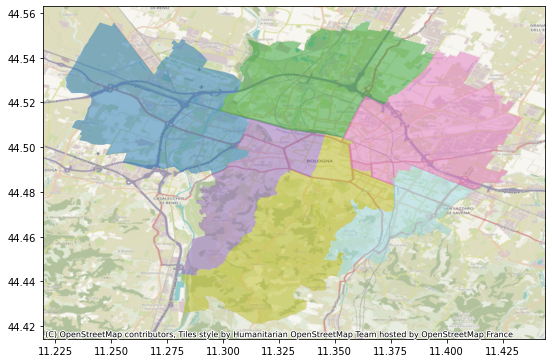

In [22]:
# Plot the neighbourhoods using contextily with a color map (tab20)
ax = neighbourhoods.plot(alpha=0.5, cmap="tab20", figsize=(9, 9))
ctx.add_basemap(ax, crs=neighbourhoods.crs.to_string(),
                source=ctx.providers.OpenStreetMap.HOT)

## Data analysis

### 3.  View statistical information on neighborhoods

#### Retrive data from http://dati.comune.bologna.it/node/1183

In [23]:
!wget http://dati.comune.bologna.it/download/file/fid/3844
!unzip 3844

--2021-01-12 10:57:03--  http://dati.comune.bologna.it/download/file/fid/3844
Resolving dati.comune.bologna.it (dati.comune.bologna.it)... 193.43.86.154
Connecting to dati.comune.bologna.it (dati.comune.bologna.it)|193.43.86.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92866 (91K) [application/zip]
Saving to: ‘3844’

3844                100%[===================>]  90.69K   156KB/s    in 0.6s    

2021-01-12 10:57:04 (156 KB/s) - ‘3844’ saved [92866/92866]

Archive:  3844
  inflating: 03.00.36 Quartieri_2016/Quartieri.dbf  
  inflating: 03.00.36 Quartieri_2016/Quartieri.prj  
  inflating: 03.00.36 Quartieri_2016/Quartieri.shp  
  inflating: 03.00.36 Quartieri_2016/Quartieri.shx  


In [24]:
# This data will be used in later consideration
data_bologna = gpd.read_file('03.00.36 Quartieri_2016/Quartieri.shp')
area_bologna = data_bologna.sort_values('AREA', ascending=False)
area_bologna

AREA  ...                                           geometry
0  3.143554e+07  ...  POLYGON ((678805.538 4936062.607, 678924.475 4...
4  3.004000e+07  ...  POLYGON ((687405.174 4929418.515, 687426.282 4...
3  2.626846e+07  ...  POLYGON ((690605.141 4934845.636, 690563.328 4...
1  2.587520e+07  ...  POLYGON ((688294.094 4935881.224, 688297.407 4...
2  1.576644e+07  ...  POLYGON ((684279.866 4931252.673, 684297.946 4...
5  1.146010e+07  ...  POLYGON ((690116.656 4928978.484, 690127.598 4...

[6 rows x 5 columns]

#### Inspect one of the neighbourhoods
- 0 : Borgo Panigale - Reno 	
- 1 : Navile
- 2 : Porto - Saragozza
- 3 : San Donato - San Vitale
- 4 : Santo Stefano
- 6 : Savena

In [25]:
# Choose a number
neighbourhoods_number = 2

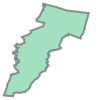

In [26]:
# Plot the shape of this neighbourhoods
neighbourhoods.geometry[neighbourhoods_number]

In [27]:
# First 5 room in the selected neighbourhood
nei_name = neighbourhoods['neighbourhood'][neighbourhoods_number]
geo_bologna[geo_bologna['neighbourhood'] == nei_name ].head(5)

id                               name  ...             x             y
1    46352         A room in Pasolini's house  ...  1.261822e+06  5.541849e+06
3    70366                         Fuoriporta  ...  1.260366e+06  5.542677e+06
6    85399          A bed in Pasolini's house  ...  1.261851e+06  5.541562e+06
7   145779                        SINGLE ROOM  ...  1.262125e+06  5.542064e+06
16  233922  Big and central studio open space  ...  1.261223e+06  5.542506e+06

[5 rows x 13 columns]

In [28]:
# Pick a random id from this 5 (it is possible to pick on the entire neighbourhood removing "head(5)")
list_id = geo_bologna[geo_bologna['neighbourhood'] == nei_name ].head(5)['id'].to_list()
random_id = random.choice(list_id)
print("id: ", random_id)
# Retrive a random host's room
random_room = geo_bologna[geo_bologna['id'] == random_id].geometry.values[0]
# Check if it is in the neighbourhood
print("the room is in the neighbourhood?")
random_room.within(neighbourhoods.geometry[neighbourhoods_number])

id:  46352
the room is in the neighbourhood?


True

In [29]:
# Retrive all the rooms in the neighbourhoods
Neighbourhood_rooms = geo_bologna[geo_bologna.within(neighbourhoods.geometry[neighbourhoods_number])]
print("The rooms in ", nei_name)
print('are ', Neighbourhood_rooms.shape[0])

The rooms in  Porto - Saragozza
are  772


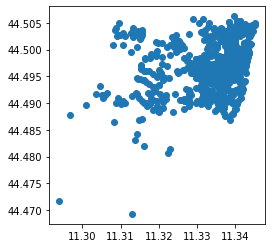

In [30]:
Neighbourhood_rooms.plot()

#### Join the data of airbnb and neighbourhoods

In [31]:
# Inner Spatial join with the options contains 
rooms_and_neighbourhoods = gpd.sjoin(neighbourhoods, geo_bologna, how='inner', op='contains', lsuffix='neighs_', rsuffix='rooms_')

In [32]:
# Look at the name of the column
rooms_and_neighbourhoods.columns

Index(['neighbourhood_neighs_', 'neighbourhood_group_neighs_', 'geometry',
       'index_rooms_', 'id', 'name', 'host_id', 'host_name',
       'neighbourhood_group_rooms_', 'neighbourhood_rooms_', 'latitude',
       'longitude', 'room_type', 'price', 'x', 'y'],
      dtype='object')

In [33]:
# Inspect the geometry of the results
rooms_and_neighbourhoods.geom_type.unique()

array(['MultiPolygon'], dtype=object)

In [34]:
# Calculate the total rooms in each neighbourhood
total_rooms_for_neighbourhoods = rooms_and_neighbourhoods.groupby(['neighbourhood_neighs_']).size().to_frame('total').reset_index().sort_values(['total', 'neighbourhood_neighs_'], ascending=False)
# Renaming column
total_rooms_for_neighbourhoods.rename(columns={'neighbourhood_neighs_':'neighbourhood'},inplace=True)
# Show the results
total_rooms_for_neighbourhoods

neighbourhood  total
4            Santo Stefano    865
2        Porto - Saragozza    772
3  San Donato - San Vitale    293
1                   Navile    245
0    Borgo Panigale - Reno     95
5                   Savena     89

In [35]:
# Data of the area of each neighbourhood 
area_bologna

AREA  ...                                           geometry
0  3.143554e+07  ...  POLYGON ((678805.538 4936062.607, 678924.475 4...
4  3.004000e+07  ...  POLYGON ((687405.174 4929418.515, 687426.282 4...
3  2.626846e+07  ...  POLYGON ((690605.141 4934845.636, 690563.328 4...
1  2.587520e+07  ...  POLYGON ((688294.094 4935881.224, 688297.407 4...
2  1.576644e+07  ...  POLYGON ((684279.866 4931252.673, 684297.946 4...
5  1.146010e+07  ...  POLYGON ((690116.656 4928978.484, 690127.598 4...

[6 rows x 5 columns]

Here is possible to see that the number of the rooms is indipendent respect to the area, and later we can see that the number of rooms is dependent on the tourist attraction

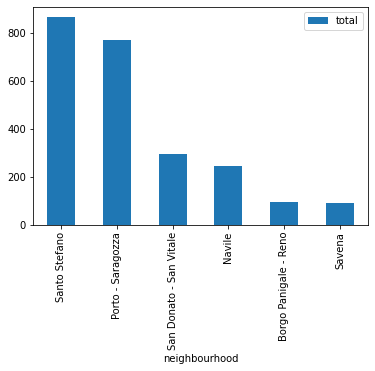

In [36]:
# Plot the results
total_rooms_for_neighbourhoods.plot.bar(x='neighbourhood')

### 4. Identify which are the neighbourhoods with the highest prices in AirBnB

In [37]:
# Calculate the mean price for each neighbourhood
avg_price = rooms_and_neighbourhoods.groupby(['neighbourhood_neighs_'])['price'].mean()
avg_price.sort_values(ascending=False)

neighbourhood_neighs_
Santo Stefano              95.224277
Porto - Saragozza          93.362694
San Donato - San Vitale    88.614334
Savena                     79.382022
Borgo Panigale - Reno      78.021053
Navile                     77.751020
Name: price, dtype: float64

### 5. Identify which are the districts with the greatest number of tourist activities

In [38]:
# Create the area of bologna using a convex hull
bologna_area = geo_bologna.unary_union.convex_hull

In [39]:
# Show the json of the results
gpd.GeoSeries([bologna_area]).to_json()

# I created a geojson using this coord and then
# I used this file to create the box for hotosm

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[11.32338, 44.4236], [11.23908, 44.529540000000004], [11.2388, 44.53112], [11.24873, 44.54527], [11.35422, 44.54849], [11.37982, 44.54824], [11.42027, 44.52324], [11.42255, 44.49886], [11.40178, 44.462959999999995], [11.32338, 44.4236]]]}, "bbox": [11.2388, 44.4236, 11.42255, 44.54849]}], "bbox": [11.2388, 44.4236, 11.42255, 44.54849]}'

In [40]:
# Retrive the geojson of bologna boundary from my github repo
bologna_boundary = gpd.read_file("https://raw.githubusercontent.com/Richip9114/GeospExam/main/bologna_area.geojson")

In [41]:
bologna_boundary

id                                           geometry
0  0  POLYGON ((11.32338 44.42360, 11.23908 44.52954...

In [42]:
bologna_boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [43]:
# Create the bounding box
bbox_geom = bologna_boundary['geometry'].values[0]


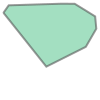

In [44]:
bbox_geom

In [45]:
# Retrive the pbf file from my github repo
# I created this file using hotosm
!wget https://github.com/Richip9114/GeospExam/raw/main/bologna.osm.pbf

--2021-01-12 10:57:07--  https://github.com/Richip9114/GeospExam/raw/main/bologna.osm.pbf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Richip9114/GeospExam/main/bologna.osm.pbf [following]
--2021-01-12 10:57:08--  https://raw.githubusercontent.com/Richip9114/GeospExam/main/bologna.osm.pbf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6314262 (6.0M) [application/octet-stream]
Saving to: ‘bologna.osm.pbf’

bologna.osm.pbf     100%[===================>]   6.02M  25.6MB/s    in 0.2s    

2021-01-12 10:57:08 (25.6 MB/s) - ‘bologna.osm.pbf’ saved [6314262/6314262]



In [46]:
!pwd

/content


In [47]:
%cd /content/

/content


In [48]:
!ls

'03.00.36 Quartieri_2016'   3844   bologna.osm.pbf   sample_data


In [49]:
# Creation of the osm variable using pyrosm
# For this task I need to pass the pbf file and the bbox
osm = pyrosm.OSM("bologna.osm.pbf", bounding_box=bbox_geom)

In [50]:
# Look at what is available in osm variable
osm.conf.tags.available

['aerialway',
 'aeroway',
 'amenity',
 'boundary',
 'building',
 'craft',
 'emergency',
 'geological',
 'highway',
 'historic',
 'landuse',
 'leisure',
 'natural',
 'office',
 'power',
 'public_transport',
 'railway',
 'route',
 'place',
 'shop',
 'tourism',
 'waterway']

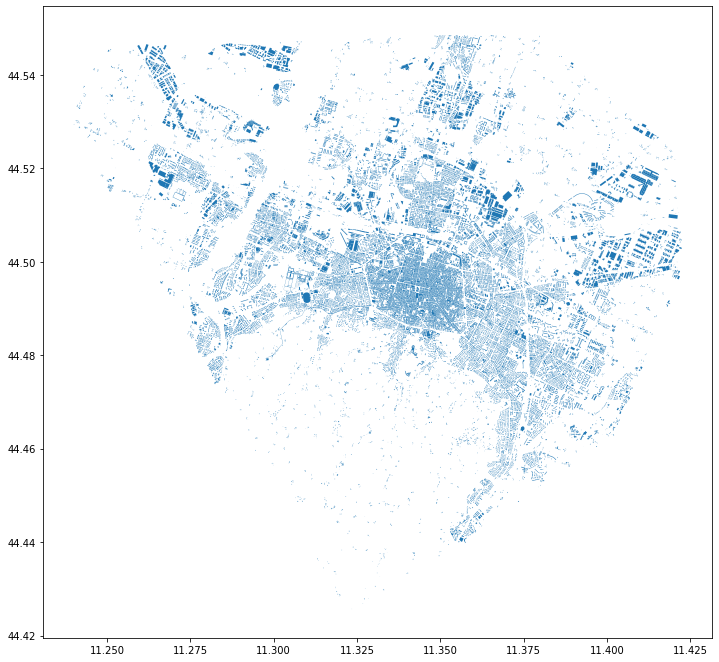

In [51]:
# Buildings of bologna, to check if all is working well
buildings = osm.get_buildings()
buildings.plot(figsize=(12,12))

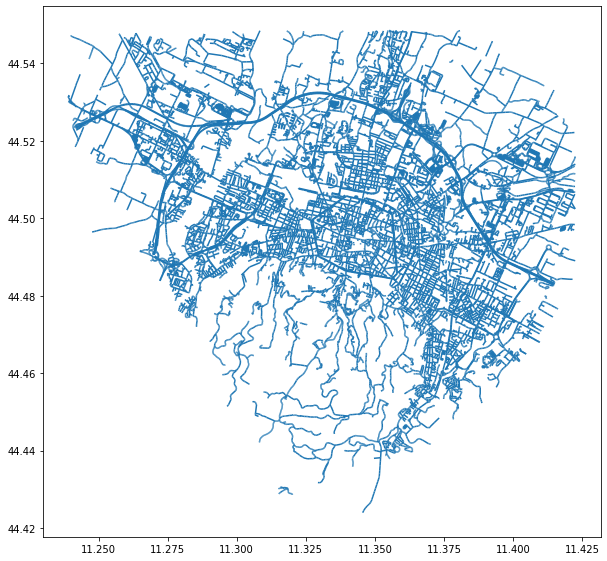

In [52]:
# Street of bologna, to check if all is working well
drive_net = osm.get_network(network_type="driving")
drive_net.plot(figsize=(10,10))

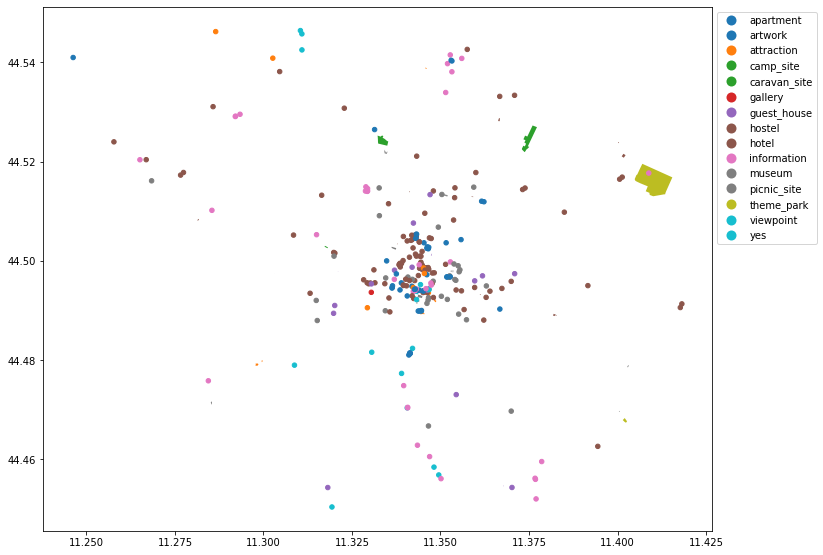

In [53]:
# Create a custom filter to extrapolate only tourism attraction
custom_filter = {'tourism': True}
# Get the data using get_pois (get points of interest)
pois = osm.get_pois(custom_filter=custom_filter)

# Plot
ax = pois.plot(column='tourism', markersize=20, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=1, bbox_to_anchor=(1, 1)))

In [54]:
# Spatial join like before but between tourism pois and neighbourhoods
tourism_and_neighbourhoods = gpd.sjoin(neighbourhoods, pois, how='inner', op='contains', lsuffix='neighs_', rsuffix='tourism_')
# Groupby the name of the neighbourhoods
total_tourismPoint_for_neighbourhoods = tourism_and_neighbourhoods.groupby(['neighbourhood']).size().to_frame('total').reset_index().sort_values(['total', 'neighbourhood'], ascending=False)
total_tourismPoint_for_neighbourhoods

neighbourhood  total
4            Santo Stefano    115
2        Porto - Saragozza     83
1                   Navile     40
3  San Donato - San Vitale     26
0    Borgo Panigale - Reno     15
5                   Savena      7

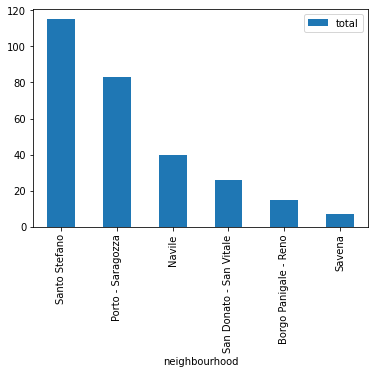

In [55]:
# Plot the results
total_tourismPoint_for_neighbourhoods.plot.bar(x='neighbourhood')

### 6. Find the location of 3 AirBnB hosts closest to one of the city's museums (on walking distance)

In [56]:
# It is important to install here osmnx because there are problems with some version in colab.
# Due to the fact that here the python version is 3.6.9, but osmnx works with pandas 1.2 and
# this version of pandas needs python >= 3.7.
# So, I need to install osmnx 0.16.2, but this is not a problem, everything works.
!pip install osmnx==0.16.2

     |████████████████████████████████| 92kB 3.7MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 11.6MB 21.3MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [57]:
import osmnx as ox

In [58]:
# Decide the best geolocator for each search, in this case arcGIS works well
# geolocator = Nominatim(user_agent="Mozilla/5.0 (Linux; Android 10) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Mobile Safari/537.36")
geolocator = ArcGIS(user_agent="Mozilla/5.0 (Linux; Android 10) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Mobile Safari/537.36")
# Palazzo Pepoli Campogrande is the city's museum of the bologna's story
location = geolocator.geocode("Palazzo Pepoli Campogrande")
# Get the coord of this point
point_museum = (location.latitude, location.longitude)

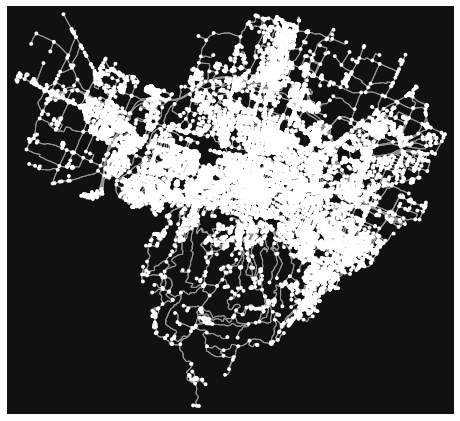

In [59]:
# Create the network of the walking street in bologna using osmnx (open street map and networkx)
G = ox.graph_from_place("Bologna, Italy", network_type='walk')
# And plot the graph
fig, ax = ox.plot_graph(G)

In [60]:
# Create the projection for the transform function
# from the epsg4326 (wgs84) to the epsg32632 for the distance in meters 
wgs84 = pyproj.CRS('EPSG:4326')
utm32n = pyproj.CRS('EPSG:32632')
projection_transform = pyproj.Transformer.from_crs(wgs84, utm32n, always_xy=False).transform

In [61]:
# Function point to create the point of the museum
shapely_point_museum = Point(point_museum)
# Transform this point in 32632
point_museum_utm32n = transform(projection_transform,shapely_point_museum)

In [62]:
# Add a new column to the geodataframe with the harvesting distance from each room to the museum
geo_bologna['distance_from_museum'] = geo_bologna.geometry.to_crs(epsg=32632).distance(point_museum_utm32n)
# And show the first 5 in line distance
geo_bologna.sort_values(by=['distance_from_museum']).head(5)

id  ... distance_from_museum
1119  17520497  ...            24.682948
575    9109831  ...            47.223033
1544  22629952  ...            61.156758
783   12820627  ...            77.859421
2160  30012669  ...            95.220759

[5 rows x 14 columns]

In [63]:
# Print the name of the nearest room in harvesting distance
geo_bologna[geo_bologna.distance_from_museum == geo_bologna.distance_from_museum.min()].name.values[0]

'Pink Master Bedroom in Penthouse w/ endless charme'

In [64]:
# Create a dictionary of the stardard walking speed in a city
hwy_walking_speeds = {
    'motorway ': 0.5,
    'trunk': 0.5,
    'primary': 0.5,
    'secondary': 0.5,
    'tertiary': 0.5,
    'unclassified': 3.5,
    'residential': 3.5,
    'service': 3.5,
    'crossing': 3.5,
    'pedestrian': 3.5,
    'living_street':3.5,
    'steps':3.5,
    'footway': 3.5,
    'track':3.5}

# And add it on my walking street graph
G = ox.add_edge_speeds(G,hwy_speeds=hwy_walking_speeds)
# Add the trave time
G = ox.add_edge_travel_times(G)

In [65]:
# Retrive the point in my graph near the museum, to calculate the walking distance 
point_nearest_museum = ox.get_nearest_node(G, point_museum)
# Add a new column with the nearest point in the graph for each room
geo_bologna['nearest_point_to_graph'] = geo_bologna.geometry.apply(lambda point: ox.get_nearest_node(G, (point.y,point.x)))
# Add a new column with the shortest ruote from museum and each room (using the nearest node calculate before)
geo_bologna['route_from_museum'] = geo_bologna.nearest_point_to_graph.apply(lambda to_point: ox.shortest_path(G, point_nearest_museum, to_point))

In [66]:
# Function to calculate the geometry from a ruote
# Copy from the course's notebook
def geometry_from_route(inG,route):
  points = []
  for idnode in route:
    lon = inG.nodes[idnode]['x']
    lat = inG.nodes[idnode]['y']
    point = Point(lon,lat)
    points.append(point)
  return(LineString(points))

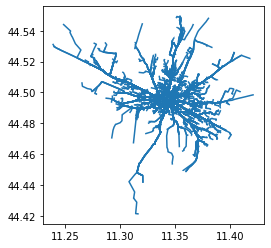

In [67]:
# Add a new column with the linestrig of the path from each room to the museum
geo_bologna['linestring'] = geo_bologna['route_from_museum'].apply(lambda route: geometry_from_route(G,route))
# And plot all the paths
geo_bologna.set_geometry('linestring').plot()

In [68]:
# Function to calculate the travel time
# Copy from the course's notebook
def travel_time_from_museum(inG, route):
  edge_times = ox.utils_graph.get_route_edge_attributes(inG, route, 'travel_time')
  return (sum(edge_times))

In [69]:
# Add a new column with the travel time for each room to the museum
geo_bologna['travel_time_from_museum'] = geo_bologna.route_from_museum.apply(lambda route: travel_time_from_museum(G,route))

In [70]:
# Function to calculate the path lenght
# Copy from the course's notebook
def lenght_path_from_museum(inG, route):
  edge_lengths = ox.utils_graph.get_route_edge_attributes(inG, route, 'length')
  return (sum(edge_lengths))

In [71]:
# Add a new column with the path lenght for each room to the museum
geo_bologna['path_lenght_from_museum'] = geo_bologna.route_from_museum.apply(lambda route: lenght_path_from_museum(G,route))

In [72]:
# Show the geodataframe with the new columns
geo_bologna.head(5)

id  ... path_lenght_from_museum
0  42196  ...                1259.702
1  46352  ...                1034.568
2  59697  ...                 838.133
3  70366  ...                2328.631
5  85368  ...                2306.450

[5 rows x 19 columns]

In [73]:
# Show the 5 rooms near in path lenght
geo_bologna.sort_values(by=['path_lenght_from_museum']).head(5)[['name','path_lenght_from_museum']]

name  path_lenght_from_museum
3269                    B&B Galleria Cavour KING DELUXE                  123.198
2422  Fontana del Nettuno Apartment! Piazza Maggiore x4                  132.813
2160                 stanza nel pieno centro di Bologna                  132.813
575         Stanza matrimoniale (double room) a Bologna                  173.645
1119  Pink Master Bedroom in Penthouse w/ endless ch...                  173.645

In [74]:
# Show the 5 rooms near in travel time
geo_bologna.sort_values(by=['travel_time_from_museum']).head(5)[['name','travel_time_from_museum']]

name  travel_time_from_museum
3269                    B&B Galleria Cavour KING DELUXE                    126.7
1360     Casa Albi. Appartamento con terrazzo a Bologna                    132.9
2422  Fontana del Nettuno Apartment! Piazza Maggiore x4                    136.6
2160                 stanza nel pieno centro di Bologna                    136.6
1869         Appartamento su 2 piani  in centro storico                    150.1

In [75]:
# Store the nearest three in travel time (from the exam's request)
nearest_three = geo_bologna.sort_values(by=['travel_time_from_museum']).head(3)
# And show them
nearest_three

id  ... path_lenght_from_museum
3269  41391171  ...                 123.198
1360  20781875  ...                 237.756
2422  32733275  ...                 132.813

[3 rows x 19 columns]

### 7. Of the three hosts, identify which one has the greatest number of services (supermarkets, pharmacies, restaurants) in an area of 300m

In [76]:
# Retrive data from OSMNX

# Supermarket
sup = {'shop': ['supermarket']}
supermarket = ox.geometries_from_place("Bologna",sup)

# Pharmacy
# 1. There are 129 pharmacies with this filter
# I decided to use this one, but I could use a custom filter with all the 3 possibilities
pha = {'amenity': ['pharmacy']}
pharmacy = ox.geometries_from_place("Bologna",pha)
# 2. There are 7 pharmacies with this filter
pha2 = {'shop': ['chemist']}
pharmacy2 = ox.geometries_from_place("Bologna",pha2)
# 3. There are 37 pharmacies with this filter
pha3 = {'healthcare': ['pharmacy']}
pharmacy3 = ox.geometries_from_place("Bologna",pha3)

# Restaurant
res = {'amenity': ['restaurant']}
restaurant = ox.geometries_from_place("Bologna",res)


In [77]:
print('The supermarkets are: ', supermarket.shape[0])
print('The pharmacies are:   ', pharmacy.shape[0])
print('The restaurants are:  ', restaurant.shape[0])

The supermarkets are:  110
The pharmacies are:    129
The restaurants are:   465


In [78]:
# Radius in meters 
meters_of_buffer = 300

#### host 1

In [79]:
host1 = nearest_three[nearest_three['id'] == 41391171].to_crs(32632).geometry.values[0]

buffer = host1.buffer(meters_of_buffer)

nr_super = supermarket.to_crs(32632)[supermarket.to_crs(32632).within(buffer)]
number_of_supermarket = nr_super.shape[0]
print("number of supermarket: ", number_of_supermarket)

nr_pharm = pharmacy.to_crs(32632)[pharmacy.to_crs(32632).within(buffer)]
number_of_pharmacy = nr_pharm.shape[0]
print("number of pharmacy: ", number_of_pharmacy)

nr_rest = restaurant.to_crs(32632)[restaurant.to_crs(32632).within(buffer)]
number_of_restaurant = nr_rest.shape[0]
print("number of restaurant: ", number_of_restaurant)

sum = number_of_supermarket + number_of_pharmacy + number_of_restaurant 
print('total: ', sum)

number of supermarket:  10
number of pharmacy:  7
number of restaurant:  40
total:  57


#### host 2

In [80]:
host2 = nearest_three[nearest_three['id'] == 41391171].to_crs(32632).geometry.values[0]

buffer = host2.buffer(meters_of_buffer)

nr_super = supermarket.to_crs(32632)[supermarket.to_crs(32632).within(buffer)]
number_of_supermarket = nr_super.shape[0]
print("number of supermarket: ", number_of_supermarket)

nr_pharm = pharmacy.to_crs(32632)[pharmacy.to_crs(32632).within(buffer)]
number_of_pharmacy = nr_pharm.shape[0]
print("number of pharmacy: ", number_of_pharmacy)

nr_rest = restaurant.to_crs(32632)[restaurant.to_crs(32632).within(buffer)]
number_of_restaurant = nr_rest.shape[0]
print("number of restaurant: ", number_of_restaurant)

sum = number_of_supermarket + number_of_pharmacy + number_of_restaurant 
print('total: ', sum)

number of supermarket:  10
number of pharmacy:  7
number of restaurant:  40
total:  57


#### host 3

In [81]:
host3 = nearest_three[nearest_three['id'] == 41391171].to_crs(32632).geometry.values[0]

buffer = host3.buffer(meters_of_buffer)

nr_super = supermarket.to_crs(32632)[supermarket.to_crs(32632).within(buffer)]
number_of_supermarket = nr_super.shape[0]
print("number of supermarket: ", number_of_supermarket)

nr_pharm = pharmacy.to_crs(32632)[pharmacy.to_crs(32632).within(buffer)]
number_of_pharmacy = nr_pharm.shape[0]
print("number of pharmacy: ", number_of_pharmacy)

nr_rest = restaurant.to_crs(32632)[restaurant.to_crs(32632).within(buffer)]
number_of_restaurant = nr_rest.shape[0]
print("number of restaurant: ", number_of_restaurant)

sum = number_of_supermarket + number_of_pharmacy + number_of_restaurant 
print('total: ', sum)

number of supermarket:  10
number of pharmacy:  7
number of restaurant:  40
total:  57


#### host 4

In [82]:
host4 = geo_bologna[geo_bologna['id'] == 42196].to_crs(32632).geometry.values[0]

buffer = host4.buffer(meters_of_buffer)

nr_super = supermarket.to_crs(32632)[supermarket.to_crs(32632).within(buffer)]
number_of_supermarket = nr_super.shape[0]
print("number of supermarket: ", number_of_supermarket)

nr_pharm = pharmacy.to_crs(32632)[pharmacy.to_crs(32632).within(buffer)]
number_of_pharmacy = nr_pharm.shape[0]
print("number of pharmacy: ", number_of_pharmacy)

nr_rest = restaurant.to_crs(32632)[restaurant.to_crs(32632).within(buffer)]
number_of_restaurant = nr_rest.shape[0]
print("number of restaurant: ", number_of_restaurant)

sum = number_of_supermarket + number_of_pharmacy + number_of_restaurant 
print('total: ', sum)

number of supermarket:  1
number of pharmacy:  2
number of restaurant:  2
total:  5


### 8. Analyze and test spatial autocorrelation of price

#### Packages

In [83]:
# rpy2 allows to use R inside a Python notebook
!pip install rpy2

In [84]:
%load_ext rpy2.ipython 

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


#### Data

In [85]:
# Creation of the dataframe for the R analysis
n = neighbourhoods
data_for_R = n.assign(avg_price=avg_price.values)

data_for_R = data_for_R.merge(total_tourismPoint_for_neighbourhoods)
data_for_R = data_for_R.rename(columns={'total':'tourism_points'})

data_for_R = data_for_R.merge(total_rooms_for_neighbourhoods)
data_for_R = data_for_R.rename(columns={'total':'nr_rooms'})

services = supermarket.append(pharmacy, ignore_index=True)
services = services.append(restaurant, ignore_index=True)
serv_nei = gpd.sjoin(n,services, how='inner', op='contains', lsuffix='_nei', rsuffix='_serv')
total_services_for_neighbourhoods = serv_nei.groupby('neighbourhood').size().to_frame('total').reset_index().sort_values(['total'], ascending=False)
data_for_R = data_for_R.merge(total_services_for_neighbourhoods)
data_for_R = data_for_R.rename(columns={'total':'services'})

data_for_R

neighbourhood neighbourhood_group  ... nr_rooms  services
0    Borgo Panigale - Reno                None  ...       95        68
1                   Navile                None  ...      245        76
2        Porto - Saragozza                None  ...      772       187
3  San Donato - San Vitale                None  ...      293        92
4            Santo Stefano                None  ...      865       231
5                   Savena                None  ...       89        50

[6 rows x 7 columns]

In [86]:
!mkdir Bologna

In [87]:
# This command allows to create the file for the R packages
data_for_R.to_file('Bologna/Bologna.shp')

#### Libraries

In [88]:
!apt install libudunits2-dev > /dev/null

In [89]:
!apt install libgdal-dev > /dev/null



Extracting templates from packages: 100%


In [90]:
%%R
# Installation of the required packages
install.packages('spdep')
install.packages('rgdal')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘e1071’, ‘gtools’, ‘raster’, ‘classInt’, ‘units’, ‘gdata’, ‘sp’, ‘spData’, ‘sf’, ‘deldir’, ‘LearnBayes’, ‘coda’, ‘expm’, ‘gmodels’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/e1071_1.7-4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 577678 bytes (564 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

In [91]:
%%R
# Import of the required packages
library(spdep)
library(rgdal)

R[write to console]: Loading required package: sp

R[write to console]: Loading required package: spData

R[write to console]: To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

R[write to console]: Loading required package: sf

R[write to console]: Linking to GEOS 3.6.2, GDAL 2.2.3, PROJ 4.9.3

R[write to console]: rgdal: version: 1.5-19, (SVN revision 1092)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
Path to GDAL shared files: /usr/local/lib/python3.6/dist-packages/fiona/gdal_data
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
Path to PROJ shared files: (autodetected)
Linking to sp version:1.4-5



In [92]:
%%R
# Load the date for the analysis
bologna <- readOGR('Bologna','Bologna')

OGR data source with driver: ESRI Shapefile 
Source: "/content/Bologna", layer: "Bologna"
with 6 features
It has 6 fields
Integer64 fields read as strings:  tourism_po nr_rooms services 


#### 1. Creating spatial weights matrices  

##### 1.1 Defining spatial neighbours

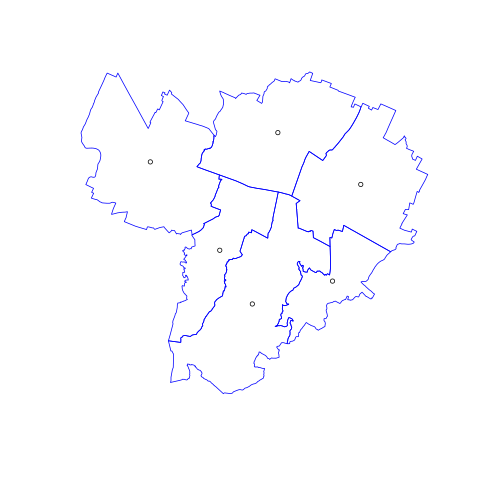

In [93]:
%%R
# Retrive and plot the centroids
coords <- coordinates(bologna)
plot(bologna, border="blue") 
points(coords, cex=0.8)

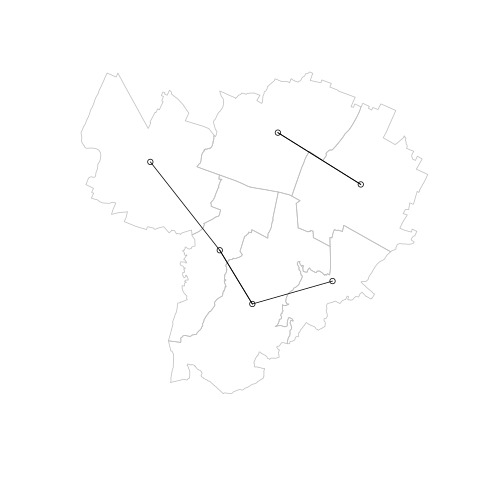

In [94]:
%%R
# k-Nearest neighbours

#With k = 1, type:
knn1IT <- knn2nb(knearneigh(coords,k=1,longlat=T))
plot(bologna, border="grey")
plot(knn1IT, coords, add=TRUE)



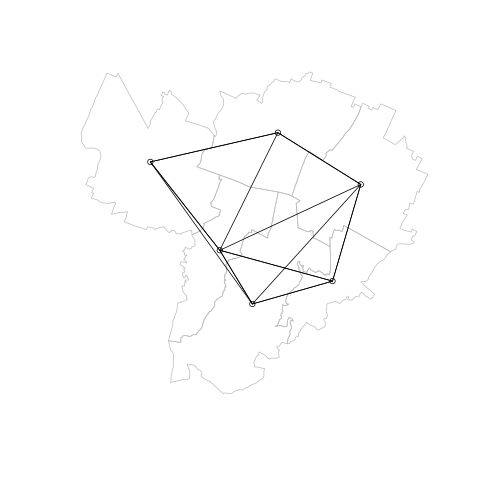

In [95]:
%%R
#With k = 3, type:
knn3IT <- knn2nb(knearneigh(coords,k=3,longlat=T))
plot(bologna, border="grey")
plot(knn3IT, coords, add=TRUE) 

In [96]:
%%R
# Critical cut-off neighbourhood

knn1IT <- knn2nb(knearneigh(coords,k=1,longlat=T))
all.linkedT <- max(unlist(nbdists(knn1IT, coords, longlat=T))) 
all.linkedT

[1] 5.249288


In [97]:
%%R
# Minimum threshold distance is equal to 5.249 km. 
# Therefore, the cut-off distance has to be greater than 5.25. 

# Different neighbourhood definitions for different cut-off
dnb525 <- dnearneigh(coords, 0, 5.25, longlat=TRUE); dnb525

Neighbour list object:
Number of regions: 6 
Number of nonzero links: 10 
Percentage nonzero weights: 27.77778 
Average number of links: 1.666667 


In [98]:
%%R
dnb725 <- dnearneigh(coords, 0, 7.25, longlat=TRUE); dnb725

Neighbour list object:
Number of regions: 6 
Number of nonzero links: 16 
Percentage nonzero weights: 44.44444 
Average number of links: 2.666667 


In [99]:
%%R
dnb925 <- dnearneigh(coords, 0, 10.25, longlat=TRUE); dnb925

Neighbour list object:
Number of regions: 6 
Number of nonzero links: 30 
Percentage nonzero weights: 83.33333 
Average number of links: 5 


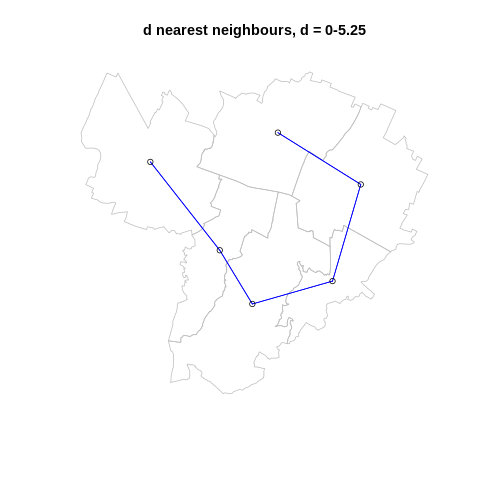

In [100]:
%%R
# Plot the results
plot(bologna, border="grey",xlab="",ylab="",xlim=NULL)
title(main="d nearest neighbours, d = 0-5.25") 
plot(dnb525, coords, add=TRUE, col="blue")

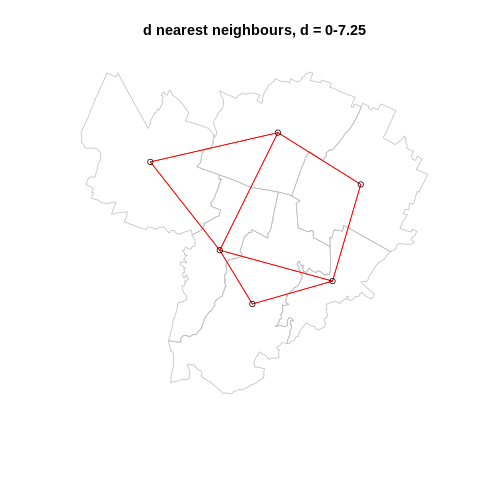

In [101]:
%%R
plot(bologna, border="grey",xlab="",ylab="",xlim=NULL)
title(main="d nearest neighbours, d = 0-7.25") 
plot(dnb725, coords, add=TRUE, col="red")

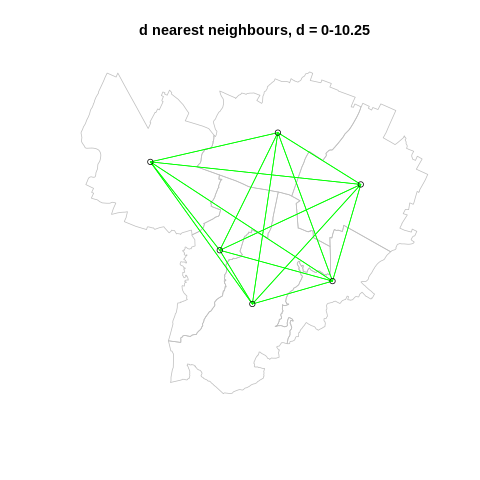

In [102]:
%%R
# With 10.25km, there are all the possible links
plot(bologna, border="grey",xlab="",ylab="",xlim=NULL)
title(main="d nearest neighbours, d = 0-10.25") 
plot(dnb925, coords, add=TRUE, col="green")

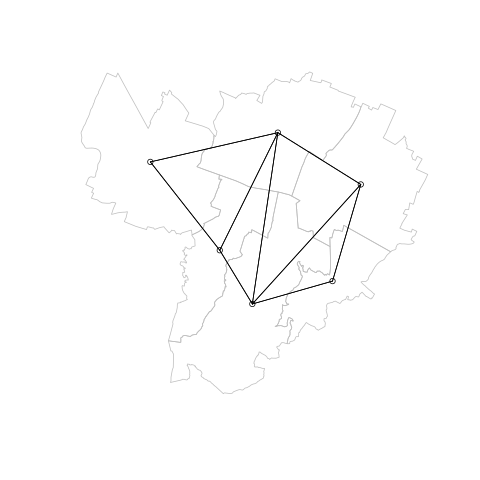

In [103]:
%%R
# Contiguity-based neighbourhood
# Neighbourohoods if they share a buondary
contnb_q <- poly2nb(bologna, queen=T)
contnb_q
plot(bologna, border="grey")
plot(contnb_q, coords, add=TRUE)

##### 1.2 Defining spatial weights

In [104]:
%%R
# Creation of a row-standardized spatial weights matrix for each critical cut-off
dnb525.listw <- nb2listw(dnb525,style="W")
dnb725.listw <- nb2listw(dnb725,style="W")
dnb925.listw <- nb2listw(dnb925,style="W")

#### 2. The Moran's I test of spatial autocorrelation 

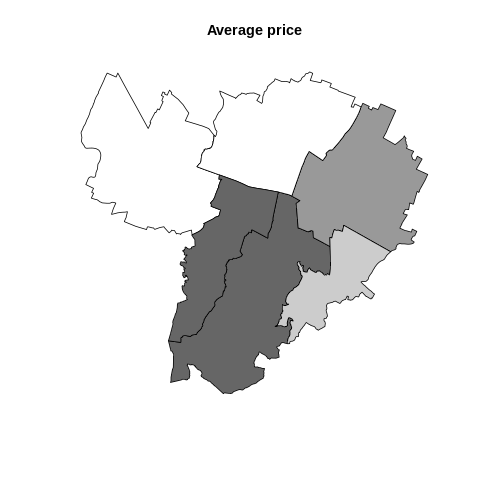

In [105]:
%%R
# Convert the average price from character to numeric
bologna$avg_price <- as.numeric(bologna$avg_price)

# Create the breaks and plot based on quantile
brks <- round(quantile(bologna$avg_price), digits=3)
colours <- grey((length(brks):2)/length(brks))
plot(bologna, col=colours[findInterval(bologna$avg_price, brks, all.inside=TRUE)])
title(main="Average price")

In [106]:
%%R
# Compute the Moran's I test
print(moran.test(bologna$avg_price, dnb525.listw, randomisation=FALSE))
print(moran.test(bologna$avg_price, dnb725.listw, randomisation=FALSE))
print(moran.test(bologna$avg_price, dnb925.listw, randomisation=FALSE))

# The results are not statistically significant because the p-value is to high


	Moran I test under normality

data:  bologna$avg_price  
weights: dnb525.listw    

Moran I statistic standard deviate = -0.51091, p-value = 0.6953
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
       -0.3918152        -0.2000000         0.1409524 


	Moran I test under normality

data:  bologna$avg_price  
weights: dnb725.listw    

Moran I statistic standard deviate = -0.31125, p-value = 0.6222
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      -0.27462682       -0.20000000        0.05748677 


	Moran I test under normality

data:  bologna$avg_price  
weights: dnb925.listw    

Moran I statistic standard deviate = 0, p-value = 0.5
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
    -2.000000e-01     -2.000000e-01      4.163336e-17 



In [107]:
%%R
# No improvement with randomization true
print(moran.test(bologna$avg_price, dnb525.listw, randomisation=TRUE))
print(moran.test(bologna$avg_price, dnb725.listw, randomisation=TRUE))
print(moran.test(bologna$avg_price, dnb925.listw, randomisation=TRUE))


	Moran I test under randomisation

data:  bologna$avg_price  
weights: dnb525.listw    

Moran I statistic standard deviate = -0.42931, p-value = 0.6662
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
       -0.3918152        -0.2000000         0.1996294 


	Moran I test under randomisation

data:  bologna$avg_price  
weights: dnb725.listw    

Moran I statistic standard deviate = -0.26449, p-value = 0.6043
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      -0.27462682       -0.20000000        0.07961202 


	Moran I test under randomisation

data:  bologna$avg_price  
weights: dnb925.listw    

Moran I statistic standard deviate = 0, p-value = 0.5
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
    -2.000000e-01     -2.000000e-01      5.551115e-17 



In [108]:
%%R
# No improvement with number of simulation = 100
print(moran.mc(bologna$avg_price, dnb525.listw, nsim=100))
print(moran.mc(bologna$avg_price, dnb725.listw, nsim=100))
print(moran.mc(bologna$avg_price, dnb925.listw, nsim=100))


	Monte-Carlo simulation of Moran I

data:  bologna$avg_price 
weights: dnb525.listw  
number of simulations + 1: 101 

statistic = -0.39182, observed rank = 41, p-value = 0.5941
alternative hypothesis: greater


	Monte-Carlo simulation of Moran I

data:  bologna$avg_price 
weights: dnb725.listw  
number of simulations + 1: 101 

statistic = -0.27463, observed rank = 44.5, p-value = 0.5594
alternative hypothesis: greater


	Monte-Carlo simulation of Moran I

data:  bologna$avg_price 
weights: dnb925.listw  
number of simulations + 1: 101 

statistic = -0.2, observed rank = 25.5, p-value = 0.7475
alternative hypothesis: greater



#### 3. The Moran's I test of spatial autocorrelation in OLS residuals

In [109]:
%%R
# The Moran's I test can also be used a to detect the presence of spatial autocorrelation in the residuals of a linear regression model. 

# Convert the variable to numeric
bologna$tourism_po <- as.numeric(bologna$tourism_po)
bologna$nr_rooms <- as.numeric(bologna$nr_rooms)
bologna$services <- as.numeric(bologna$services)

# Compute the model
LinearSolow <- lm(avg_price ~ tourism_po + nr_rooms + services, bologna)
summary(LinearSolow) 

# The results shows that the number of the rooms is slightly correlated to the price
# The tourism points is not statistically significant due to the p-value


Call:
lm(formula = avg_price ~ tourism_po + nr_rooms + services, data = bologna)

Residuals:
       0        1        2        3        4        5 
-1.72601  0.07585 -2.05805  2.95037  1.03388 -0.27604 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) 72.41625    4.87504  14.854   0.0045 **
tourism_po  -0.31189    0.15869  -1.965   0.1883   
nr_rooms     0.03106    0.02613   1.189   0.3565   
services     0.13321    0.13406   0.994   0.4251   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.921 on 2 degrees of freedom
Multiple R-squared:  0.9466,	Adjusted R-squared:  0.8664 
F-statistic: 11.81 on 3 and 2 DF,  p-value: 0.07908



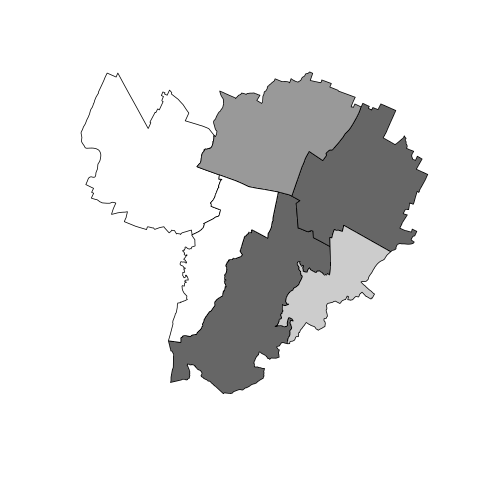

In [110]:
%%R
# The dependence in the residuals is not important because the model is not good
studres <- rstudent(LinearSolow)
resdistr <- quantile(studres) 
colours <- grey((length(resdistr):2)/length(resdistr))
plot(bologna, col=colours[findInterval(studres, resdistr, all.inside=TRUE)])


In [111]:
%%R
# Moran's I test on residuals
print(lm.morantest(LinearSolow,dnb525.listw,resfun=rstudent))
print(lm.morantest(LinearSolow,dnb725.listw,resfun=rstudent))
print(lm.morantest(LinearSolow,dnb925.listw,resfun=rstudent))

# Here the last model has a low p-value but is not important,
#  due tu the previus p-value of the model.


	Global Moran I for regression residuals

data:  
model: lm(formula = avg_price ~ tourism_po + nr_rooms + services, data
= bologna)
weights: dnb525.listw

Moran I statistic standard deviate = -0.085306, p-value = 0.534
alternative hypothesis: greater
sample estimates:
Observed Moran I      Expectation         Variance 
      0.08506595       0.10831267       0.07426114 


	Global Moran I for regression residuals

data:  
model: lm(formula = avg_price ~ tourism_po + nr_rooms + services, data
= bologna)
weights: dnb725.listw

Moran I statistic standard deviate = -0.25037, p-value = 0.5988
alternative hypothesis: greater
sample estimates:
Observed Moran I      Expectation         Variance 
    -0.009070742      0.034471484      0.030246231 


	Global Moran I for regression residuals

data:  
model: lm(formula = avg_price ~ tourism_po + nr_rooms + services, data
= bologna)
weights: dnb925.listw

Moran I statistic standard deviate = NaN, p-value = NA
alternative hypothesis: greater
sample 

#### 4. Local

##### 1. Moran scatterplot  


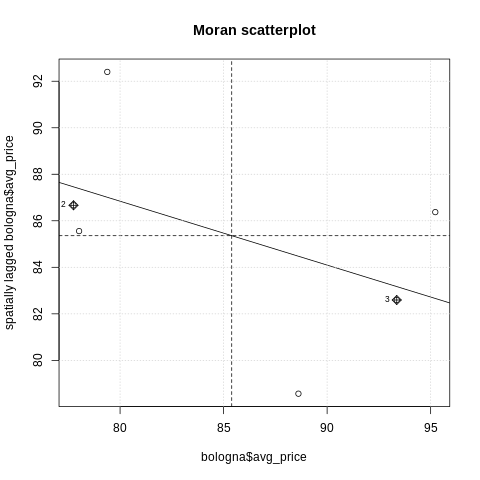

In [112]:
%%R
dnb625 <- dnearneigh(coordinates(bologna), 0, 6.25, longlat=TRUE)
dnb625.listw <- nb2listw(dnb625,style="W",zero.policy=F)
mplot <- moran.plot(bologna$avg_price, listw=dnb625.listw, main="Moran scatterplot", 
         return_df=F)
grid()

# It possible to see the point in the High-Low and Low-High quadrant that identify 
# local pattern of negative spatial autocorrelation

##### 2. The Local Moran's I 

In [113]:
%%R
# The plot can not provide the statistical significance. So, is important to
# do the local Moran's I index, based on a critical cut-off distance of 6.25km
lmI <- localmoran(bologna$avg_price, dnb625.listw)
head(lmI)

# The results prove that there are not local spatial autocorrelation due to the p-value

           Ii E.Ii     Var.Ii       Z.Ii Pr(z > 0)
1 -0.02274847 -0.2 0.34780122  0.3005553 0.3818768
2 -0.18278892 -0.2 0.16000000  0.0430277 0.4828397
3 -0.41888241 -0.2 0.06609939 -0.8513578 0.8027147
4 -0.41309183 -0.2 0.34780122 -0.3613277 0.6410728
5  0.18094473 -0.2 0.34780122  0.6459463 0.2591571
6 -0.79119401 -0.2 0.16000000 -1.4779850 0.9302941


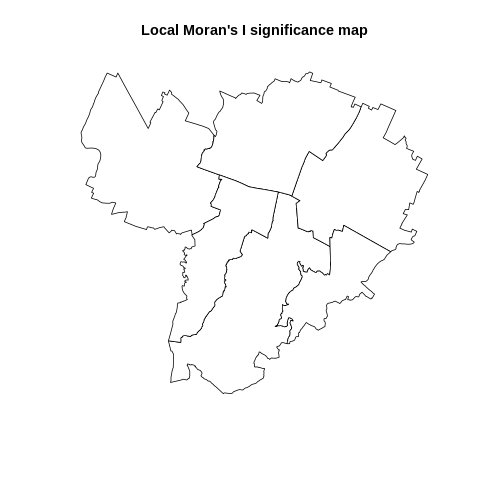

In [114]:
%%R
# We can investigate the p-value and plot the results
pval <- as.numeric(lmI[,5])
bologna$colpval[pval>0.05] <- "white" 
bologna$colpval[pval<=0.05 & pval>0.01] <- gray(0.9) 
bologna$colpval[pval<=0.01 & pval>0.001] <- gray(0.7)
bologna$colpval[pval<=0.001 & pval>0.0001] <- gray(0.4)
bologna$colpval[pval<=0.0001] <- "black"

plot(bologna, col=bologna$colpval)
legend(x=-10, y=73, legend=c("Not significant", 
       "p-value = 0.05", "p-value = 0.01", "p-value = 0.001", 
       "p-value = 0.0001"), fill=c("white", gray(0.9), gray(0.7),    
       gray(0.4), "black"), bty="n", cex=0.8)
title(main="Local Moran's I significance map")

# There is not significance

### 9. Represent these analyses on maps (web)

#### Map of Bologna

In [115]:
import folium
from branca.element import Figure

In [116]:
# Get the coords of bologna usign geopandas geocode
bologna_coord = gpd.tools.geocode('Bologna', provider="arcgis")
bologna_coord

geometry  address
0  POINT (11.34507 44.50484)  Bologna

In [117]:
loc=[44.50484,11.34507]

In [118]:
# Create an interactive map of bologna using folium
bologna_map=folium.Map(location=loc)
bologna_map

In [119]:
# Create another interactive map of bologna with more layers
fig1=Figure(width=550,height=350)
bologna_map1=folium.Map(location=loc)
fig1.add_child(bologna_map1)
folium.TileLayer('Stamen Terrain').add_to(bologna_map1)
folium.TileLayer('Stamen Toner').add_to(bologna_map1)
folium.TileLayer('Stamen Water Color').add_to(bologna_map1)
folium.TileLayer('cartodbpositron').add_to(bologna_map1)
folium.TileLayer('cartodbdark_matter').add_to(bologna_map1)
folium.LayerControl().add_to(bologna_map1)
bologna_map1


#### Map with the centroid of the neighbourhoods

In [120]:
# Creating Basemap
fig_for_marker=Figure(width=800,height=600)
map_for_marker=folium.Map(location=loc,tiles='cartodbpositron',zoom_start=12)

In [121]:
# Function from the course's notebook
def getMarker(lat, lon, message, tip, icon):
  marker = folium.Marker(location=[lat,lon],
                         popup=message,
                         tooltip=tip,
                         icon=icon)
  return marker

In [122]:
nnn = neighbourhoods
nnn['centroid'] = nnn.geometry.centroid
nnn['x'] = nnn.centroid.x
nnn['y'] = nnn.centroid.y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [123]:
# Show the map with the centroid of the neighbourhoods
for id, r in nnn.iterrows():
  icon = folium.Icon(color='blue',prefix='fa',icon='map_marker')
  marker = getMarker(r['y'],r['x'],r['neighbourhood'],r['neighbourhood'], icon)
  marker.add_to(map_for_marker)

fig_for_marker.add_child(map_for_marker)
map_for_marker

#### Map with the 3 nearest hosts and the musuem

In [124]:
# Creating Basemap
fig_for_marker3=Figure(width=800,height=600)
map_for_marker3=folium.Map(location=loc,tiles='cartodbpositron',zoom_start=14)

In [125]:
# Function with the icon
def getMarker_bed(lat,lon, message,tip):
  marker = folium.Marker(location=[lat,lon],
                         popup=message,
                         tooltip=tip,
                         icon=folium.Icon(color='blue',prefix='fa',icon='bed'))
  return marker

In [126]:
# Show the map with the three nearest hosts to the museum
for id, r in nearest_three.iterrows():
  marker = getMarker_bed(r.geometry.y,r.geometry.x,r['host_name'],r['name'])
  marker.add_to(map_for_marker3)

marker_museum = folium.Marker(location=[point_museum[0],point_museum[1]],
                         popup='museum',
                         tooltip='Palazzo Pepoli - Museum of the city',
                         icon=folium.Icon(color='green',prefix='fa',icon='building'))
marker_museum.add_to(map_for_marker3)

fig_for_marker3.add_child(map_for_marker3)
map_for_marker3

#### Marker Cluster of the services

In [127]:
from folium.plugins import MarkerCluster

In [128]:
fig6=Figure(width=800,height=600)
m6=folium.Map(location=loc,tiles='cartodbpositron',zoom_start=11)
marker_cluster = MarkerCluster().add_to(m6)
for index, row in services.iterrows():
  icon=folium.Icon(color='yellow',prefix='fa',icon='star')
  message = 'no action on click'
  tip = '<strong>service: '+ str(row['shop'])
  marker = getMarker(row.geometry.centroid.y,row.geometry.centroid.x,message, tip, icon)
  #add to marker cluster 
  marker.add_to(marker_cluster)
fig6.add_child(m6)
m6


### 10. Raster data

In [129]:
!pip install rasterio

In [130]:
import rasterio
from rasterio import MemoryFile
from rasterio.plot import show

In [140]:
# Download data from my repo in github
## It is possible to download also other part of the city:
### - 220SE.tif
### - 220NO.tif
### - 220SO.tif
!wget https://github.com/Richip9114/GeospExam/raw/main/files_from_geoportale_emiliaromagna/220NE.tif


--2021-01-12 11:08:56--  https://github.com/Richip9114/GeospExam/raw/main/files_from_geoportale_emiliaromagna/220NE.tif
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Richip9114/GeospExam/main/files_from_geoportale_emiliaromagna/220NE.tif [following]
--2021-01-12 11:08:56--  https://raw.githubusercontent.com/Richip9114/GeospExam/main/files_from_geoportale_emiliaromagna/220NE.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2321720 (2.2M) [image/tiff]
Saving to: ‘220NE.tif’

220NE.tif           100%[===================>]   2.21M  --.-KB/s    in 0.1s    

2021-01-12 11:08:57 (18.9 MB/s) - ‘220NE.ti

In [142]:
file_NE = "220NE.tif"

In [143]:
# Open the tif file
raster = rasterio.open(file_NE)

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


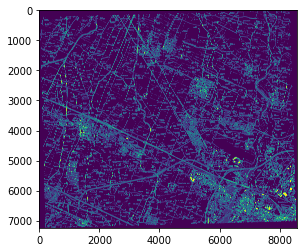

In [144]:
# Show the raster
show(raster)

In [145]:
print('raster wifth: ', raster.width)
print('raster height: ', raster.height)

raster wifth:  8583
raster height:  7238


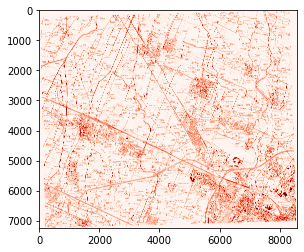

In [146]:
show((raster, 1), cmap='Reds')

## Requirements

In [137]:
!pip freeze > requirements.txt

In [138]:
# from google.colab import files
# files.download('requirements.txt')